<a href="https://colab.research.google.com/github/BYK82/AIFFEL/blob/main/%5BE_16%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 16-13. 프로젝트 : Segmentation map으로 도로 이미지 만들기

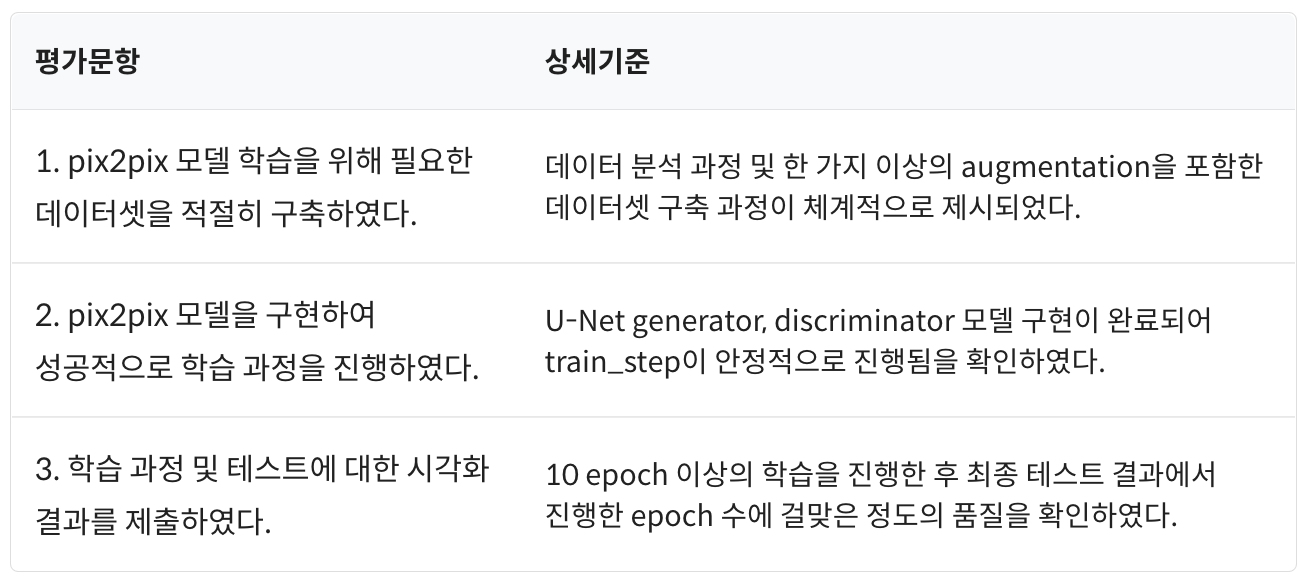

1. 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해 주세요.

  (어떠한 방법을 사용했는지 적어주세요.)

2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해 주세요.

3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운로드했던 "val" 폴더 내 이미지를 사용해 주세요.

4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.

5. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.


In [ ]:
import os 
import tensorflow as tf
from tensorflow.keras import layers, Input, Model
import numpy as np
import matplotlib.pyplot as plt
import imageio 
import os
import cv2
import time
import tensorflow as tf   #신경망
from tensorflow import data   #데이터
from tensorflow import image   #이미지 처리
import tensorflow_datasets as tfds   #데이터셋
from tensorflow.keras import losses   #손실값
from tensorflow.keras import optimizers   #옵티마이저
from tensorflow.keras import layers, Input, Model   #레이어
from tensorflow.keras.preprocessing.image import random_rotation   #이미지 보강

## STEP 1. 데이터 준비하기 (Augmentation 방법 적용 + 방법 설명)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = '/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 16/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


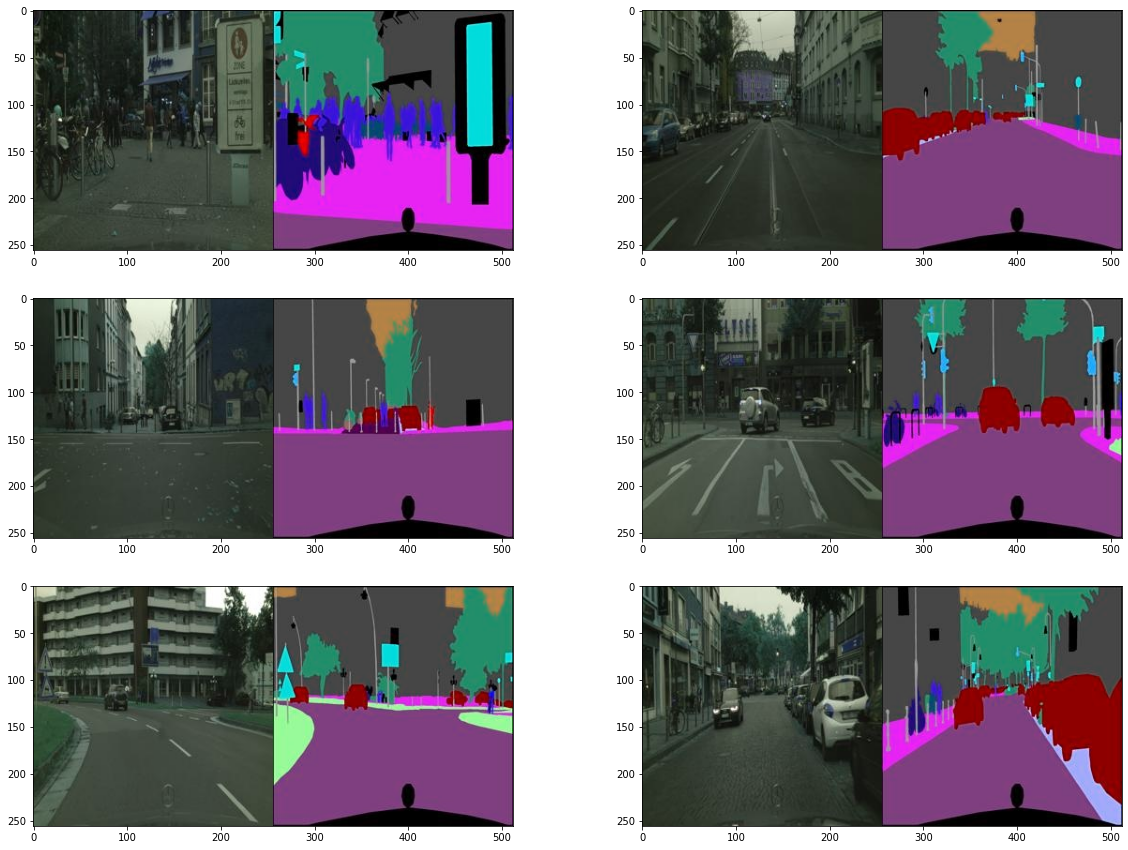

In [ ]:
# 이미지 확인
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[i]

    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [ ]:
# 이미지 shape 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


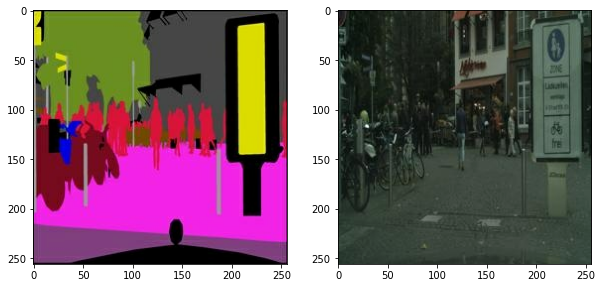

In [ ]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(colored), normalize(sketch)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [ ]:
# 학습에 사용하는 데이터의 다양성을 높이기 위해 아래 코드와 같이 여러 augmentation 방법을 적용

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   


1. 두 이미지가 채널 축으로 연결됩니다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 됩니다.
2. 1.의 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용됩니다. (tf.pad)
3. 2.의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냅니다. (tf.image.random_crop)
4. 3.의 결과를 50% 확률로 가로로 뒤집습니다. (tf.image.random_flip_left_right)
5. 4.의 결과를 50% 확률로 세로로 뒤집습니다. (tf.image.random_flip_up_down)
6. 5.의 결과를 50% 확률로 회전시킵니다. (tf.image.rot90)

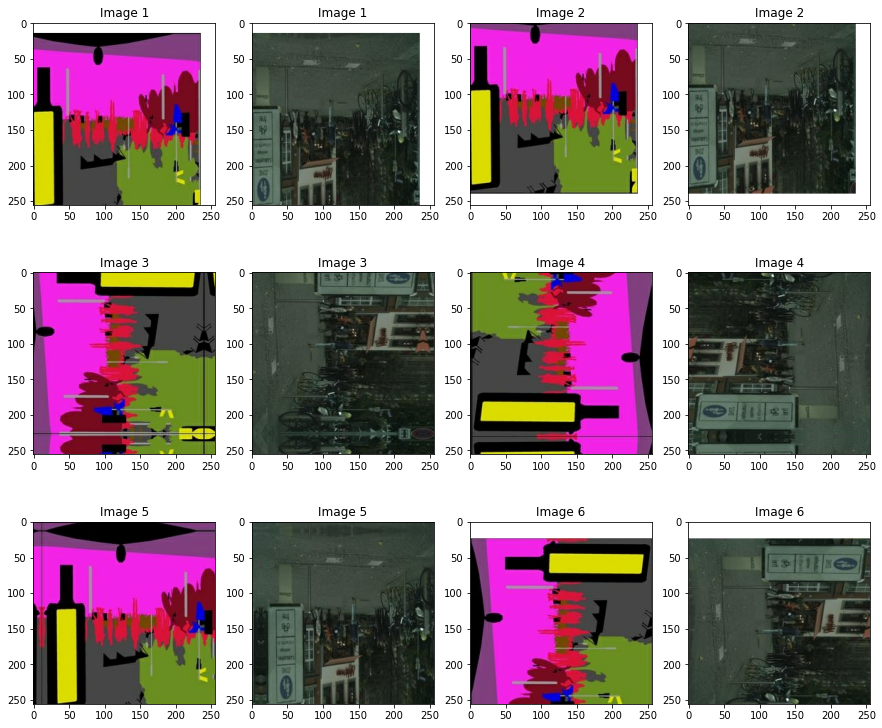

In [ ]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

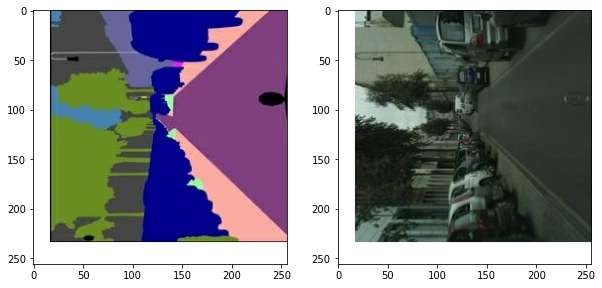

In [ ]:
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## STEP 2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해 주세요.

In [ ]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)


class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [ ]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block (EncodeBlock)     (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_1 (EncodeBlock)   (None, 64, 64, 128)  131584      ['encode_block[0][0]']           
                                                                                              

In [ ]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x
        
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        #첫 번째 블록은 단순한 연결(concat)을 수행.
        self.block1 = layers.Concatenate()
        
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        
        #Discriminator의 최종 출력은 sigmoid 활성화를 사용.
        self.sigmoid = layers.Activation("sigmoid")
        
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

# STEP 3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운로드했던 "val" 폴더 내 이미지를 사용해 주세요.

  모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

In [ ]:
# 손실함수 정의

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

# 옵티마이저 정의

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

# 학습 방식 정의

@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [ ]:
val_data_path = '/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 16/cityscapes/val/'
val_path = [val_data_path + path for path in os.listdir(val_data_path)]

save_images = []
for path in val_path:
    img, _ = load_img(path)
    save_images.append(img)

save_images = np.array(save_images)

def save_val_img(path):
    predict = generator(save_images)
    predict = denormalize(predict)

    plt.figure(figsize=(4, 4))
    plt.subplots_adjust(wspace=0.05, hspace=0.1)
    for i in range(4):
        plt.subplot(2, 2, 1+i)
        plt.imshow(predict[i])
        plt.axis("off")
    plt.savefig(path)
    plt.clf()

In [ ]:
val_path

['/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 16/cityscapes/val/1.jpg',
 '/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 16/cityscapes/val/2.jpg',
 '/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 16/cityscapes/val/3.jpg',
 '/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 16/cityscapes/val/4.jpg',
 '/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 16/cityscapes/val/5.jpg']

In [ ]:
EPOCHS = 500

gen_loss_list, dis_loss_list, L1_loss_list = [], [], []

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    
    if (epoch + 1) % 10 == 0:
        print(epoch)
        save_val_img(f"/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 16/cityscapes/img/{epoch}.png")
    
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
        
        gen_loss_list.append(g_loss)
        dis_loss_list.append(d_loss)
        L1_loss_list.append(l1_loss)
                
        #손실을 출력                                                                     
        if (i+1) % 200 == 0 and (epoch + 1) % 50 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

9
19
29
39
49
EPOCH[49] - STEP[200]                     
Generator_loss:0.7984                     
L1_loss:0.1854                     
Discriminator_loss:0.9796

59
69
79
89
99
EPOCH[99] - STEP[200]                     
Generator_loss:1.1274                     
L1_loss:0.1678                     
Discriminator_loss:0.6263

109
119
129
139
149
EPOCH[149] - STEP[200]                     
Generator_loss:1.4892                     
L1_loss:0.1731                     
Discriminator_loss:0.3456

159
169
179
189
199
EPOCH[199] - STEP[200]                     
Generator_loss:1.3852                     
L1_loss:0.1543                     
Discriminator_loss:1.1443

209


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


219
229
239
249
EPOCH[249] - STEP[200]                     
Generator_loss:1.9387                     
L1_loss:0.1545                     
Discriminator_loss:0.6609

259
269
279
289
299
EPOCH[299] - STEP[200]                     
Generator_loss:0.3864                     
L1_loss:0.1846                     
Discriminator_loss:1.4115

309
319
329
339
349
EPOCH[349] - STEP[200]                     
Generator_loss:1.3391                     
L1_loss:0.1342                     
Discriminator_loss:0.5528

359
369
379
389
399
EPOCH[399] - STEP[200]                     
Generator_loss:1.2197                     
L1_loss:0.1479                     
Discriminator_loss:0.7202

409
419
429
439
449
EPOCH[449] - STEP[200]                     
Generator_loss:0.5825                     
L1_loss:0.1419                     
Discriminator_loss:1.2291

459
469
479
489
499
EPOCH[499] - STEP[200]                     
Generator_loss:1.3369                     
L1_loss:0.1478                     
Discriminat

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

## STEP 4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.

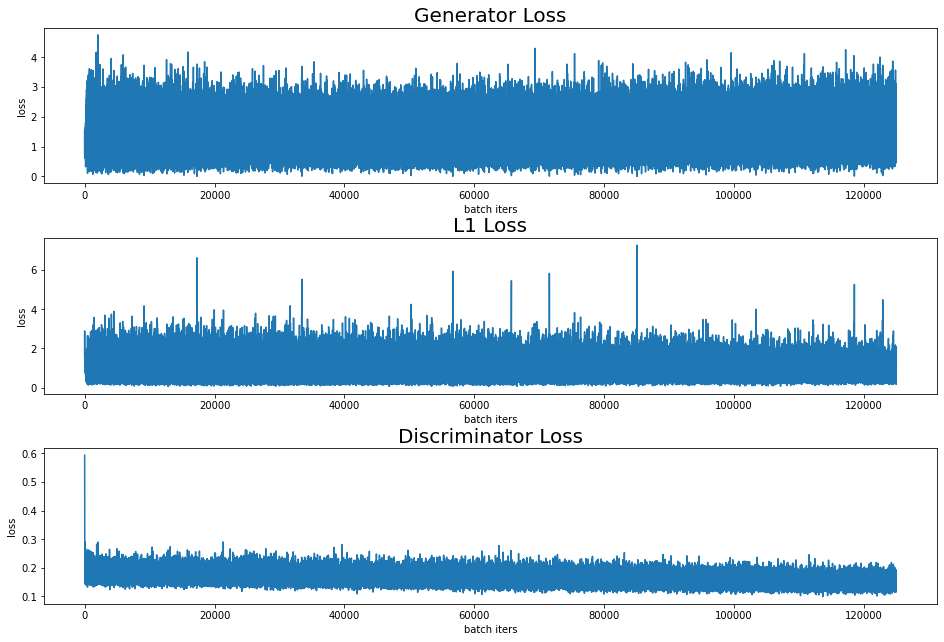

In [ ]:
plt.figure(figsize=(16,10))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)

plt.subplot(3, 1, 1)
plt.plot(gen_loss_list)
plt.ylabel('loss')  
plt.xlabel('batch iters')  
plt.title('Generator Loss', fontsize=20)

plt.subplot(3, 1, 2) 
plt.plot(dis_loss_list)
plt.ylabel('loss')  
plt.xlabel('batch iters')  
plt.title('L1 Loss', fontsize=20)

plt.subplot(3, 1, 3)
plt.plot(L1_loss_list)
plt.ylabel('loss')  
plt.xlabel('batch iters')  
plt.title('Discriminator Loss', fontsize=20)

plt.show()

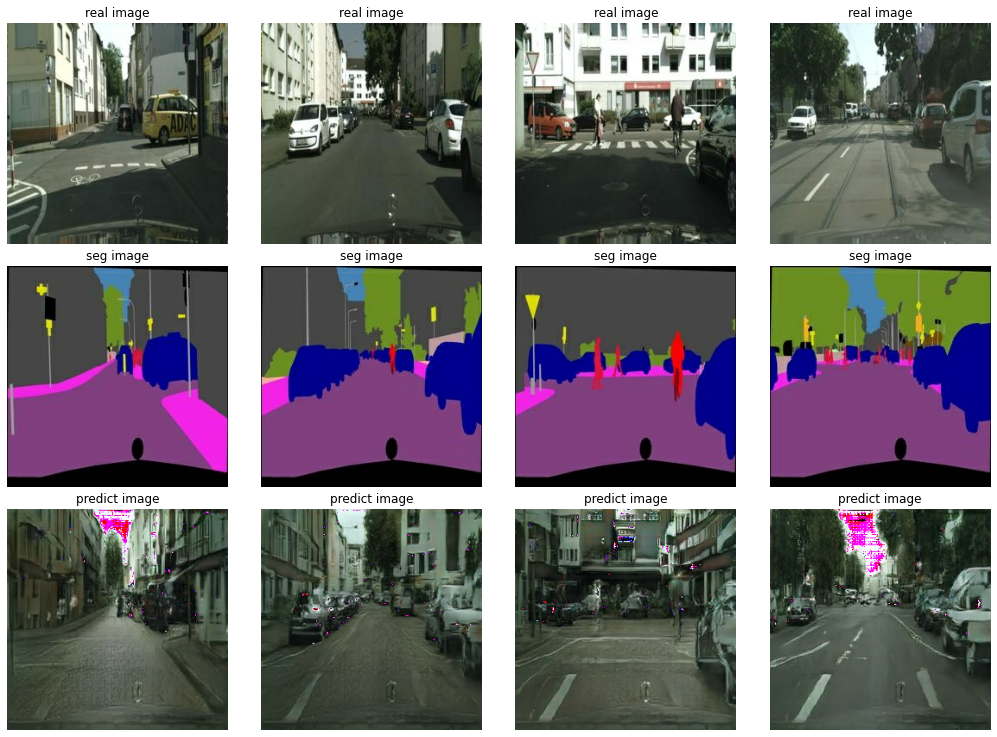

In [ ]:
val_path = [val_data_path + path for path in os.listdir(val_data_path)]

seg_images, real_images = [], []
for path in val_path:
    seg_img, real_img = load_img(path)
    seg_images.append(seg_img)
    real_images.append(real_img)

seg_images = np.array(seg_images)

real_images = np.array(real_images)
real_images = (real_images + 1) * 127.5
real_images = real_images.astype(np.uint8)

predict = generator(seg_images)
predict = denormalize(predict)

seg_images = (seg_images + 1) * 127.5
seg_images = seg_images.astype(np.uint8)

plt.figure(figsize=(18, 13))
plt.subplots_adjust(wspace=0.05, hspace=0.1)
for i in range(4):
    plt.subplot(3, 4, i + 1)
    plt.imshow(real_images[i])
    plt.title("real image")
    plt.axis("off")
    
    plt.subplot(3, 4, i + 5)
    plt.imshow(seg_images[i])
    plt.title("seg image")
    plt.axis("off")
    
    plt.subplot(3, 4, i + 9)
    plt.imshow(predict[i])
    plt.title("predict image")
    plt.axis("off")

In [ ]:
epoch_nums = [int(path.replace(".png", "")) for path in os.listdir("/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 16/cityscapes/img/")]
epoch_nums.sort()

img_path_list = [f"/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 16/cityscapes/img/{epoch}.png" for epoch in epoch_nums]
img_list = [cv2.imread(img_path) for img_path in img_path_list]

imageio.mimsave("/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 16/cityscapes/frame.gif", img_list)

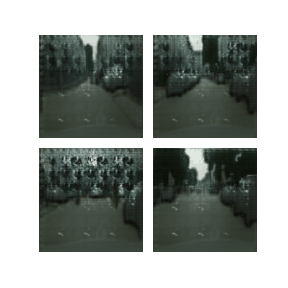

In [ ]:
from IPython.display import Image

fname = "/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 16/cityscapes/frame.gif"
Image(open(fname , 'rb').read())  # local

## 회고 

- 여전히 GAN 이 무엇인지 이해를 못한 상태에서 코드를 복사붙여넣기 했다. 뒤죽박죽으로 섞여버려서 처음 학습을 시켰을 땐 segmented와 real 이미지 순서를 바꿔서 결과 이미지가 다 segmented 색상으로 나와버렸다. 문제는 학습에 4시간정도 걸렸다는 거다. 끈기를 가지고 다시 바꿔서 돌리니 결과는 제대로 나왔다. 하지만 퀄리티는 500 epoch이나 돌렸는데도 불구하고 무슨 귀신의 집 같이 나왔다. 

- 지난주에 했던 GAN 과 달리 스케치를 넣어주고 거기에 맞는 이미지를 생성한다는 것이 다른 점인 것 같지만 어떻게 돌아가는지 이해하지 못한다면 이건 그냥 코드 복붙으로 끝날 것 같다. 공부가 필요하다.

- gif 파일을 만들고 다시 읽어드리는 건 처음 해봤는데 새로운 것을 배울 수 있었다.

